In [1]:
import tensorflow as tf
import simpleaudio as sa
from scipy.signal import resample
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = 'data/audio/SMC_013.wav'

audio = tf.io.read_file(file_path)
audio, sample_rate = tf.audio.decode_wav(audio)

In [3]:
def resample_signal(x, src_rate, tgt_rate):
    new_total_samples = int(tgt_rate * len(x.numpy()) / src_rate.numpy())
    return resample(x, new_total_samples)

In [4]:
resampled_audio = resample_signal(audio, sample_rate, 11025)

In [6]:
sa.play_buffer(resampled_audio, 1, 4, 11025)
sa.play_buffer(audio, 1, 4, 44100)

In [7]:
Lx = 110 #Lx = 11025
Ly = 44 #Ly = 4410

baseline = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, dropout=0.1, recurrent_dropout=0.1, input_shape=(Lx, 1)),
    tf.keras.layers.Dense(Ly, activation='sigmoid')
])

baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 44)                11308     
Total params: 275,500
Trainable params: 275,500
Non-trainable params: 0
_________________________________________________________________


In [8]:
X = tf.random.normal((1024, Lx, 1))
y = tf.random.uniform((1024, Ly), 0, 2, dtype=tf.int32)

In [9]:
baseline.compile(optimizer='rmsprop', loss='binary_crossentropy')
baseline.fit(X, y, epochs=2, batch_size=32)

Train on 1024 samples
Epoch 1/2
1024/1024 [==============================] - 12s 12ms/sample - loss: 0.6935
Epoch 2/2
1024/1024 [==============================] - 11s 11ms/sample - loss: 0.6931


In [10]:
preds = baseline.predict(X[0:1, :, :])

In [11]:
beats = tf.where(tf.math.greater(preds, 0.5), tf.constant(1), tf.constant(0))

In [12]:
beats

<tf.Tensor: shape=(1, 44), dtype=int32, numpy=
array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0]],
      dtype=int32)>

In [5]:
tag = file_path.replace('audio','annotations').split('/')
file_folder, tag = tag[0] + '/' + tag[1] + '/', tag[2][0:7]

In [9]:
files

['SMC_013_1_2_1_a.txt']

In [8]:
files = [i for i in os.listdir(file_folder) if os.path.isfile(os.path.join(file_folder,i)) and \
         tag in i]

In [10]:
if len(files) == 1:
    tag_file = file_folder + files[0]
else:
    tag_file = None
tag_file

'data/annotations/SMC_013_1_2_1_a.txt'

In [11]:
tags = [float(line.rstrip('\n')) for line in open(tag_file)]

In [35]:
# x = read_audio
# y = read_tags
def create_label_tensor(x, tags):
    positions = [int(11025*tag) for tag in tags]
    values = [1 for i in range(len(positions))]
    beat_tag = np.zeros(x.size)
    beat_tag.flat[positions] = values
    return beat_tag 

beat_tag = create_label_tensor(resampled_audio, tags)

In [55]:
def plot_beats(audio, beats):
    beat_tag = list(beats)
    xcoords = [i for i, num in enumerate(beat_tag) if num == 1] 
    plt.plot(audio, alpha = 0.5)
    for xc in xcoords:
        plt.axvline(x=xc, c='r', ls='--', lw=1)
    plt.show()

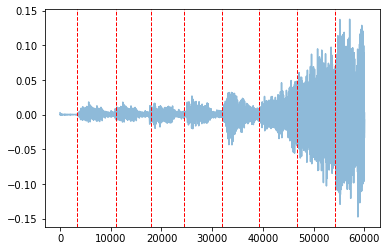

In [61]:
plot_beats(resampled_audio[:60000], beat_tag[:60000])

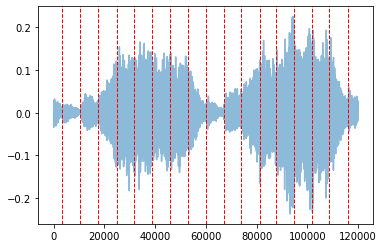

In [62]:
plot_beats(resampled_audio[80000:200000], beat_tag[80000:200000])